# Multi-Layer Perceptron, MNIST
---
In this notebook, we will train an MLP to classify images from the [MNIST database](http://yann.lecun.com/exdb/mnist/) hand-written digit database.

The process will be broken down into the following steps:
>1. Load and visualize the data
2. Define a neural network
3. Train the model
4. Evaluate the performance of our trained model on a test dataset!

Before we begin, we have to import the necessary libraries for working with data and PyTorch.

In [1]:
# import libraries
import torch
import numpy as np
import matplotlib.pyplot as plt


In [2]:
"""Load from /home/USER/data/mnist or elsewhere; download if missing."""

import gzip
import os
from urllib.request import urlretrieve
import numpy as np


def mnist(path=None):
    r"""Return (train_images, train_labels, test_images, test_labels).

    Args:
        path (str): Directory containing MNIST. Default is
            /home/USER/data/mnist or C:\Users\USER\data\mnist.
            Create if nonexistant. Download any missing files.

    Returns:
        Tuple of (train_images, train_labels, test_images, test_labels), each
            a matrix. Rows are examples. Columns of images are pixel values.
            Columns of labels are a onehot encoding of the correct class.
    """
    url = 'http://yann.lecun.com/exdb/mnist/'
    files = ['train-images-idx3-ubyte.gz',
             'train-labels-idx1-ubyte.gz',
             't10k-images-idx3-ubyte.gz',
             't10k-labels-idx1-ubyte.gz']

    if path is None:
        # Set path to /home/USER/data/mnist or C:\Users\USER\data\mnist
        path = os.path.join(os.path.expanduser('~'), 'data', 'mnist')

    # Create path if it doesn't exist
    os.makedirs(path, exist_ok=True)

    # Download any missing files
    for file in files:
        if file not in os.listdir(path):
            urlretrieve(url + file, os.path.join(path, file))
            print("Downloaded %s to %s" % (file, path))
    print("All files are ready to gzip!")

    def _images(path):
        """Return images loaded locally."""
        with gzip.open(path) as f:
            # First 16 bytes are magic_number, n_imgs, n_rows, n_cols
            pixels = np.frombuffer(f.read(), 'B', offset=16)
        return pixels.reshape(-1, 784).astype('float32') / 255

    def _labels(path):
        """Return labels loaded locally."""
        with gzip.open(path) as f:
            # First 8 bytes are magic_number, n_labels
            integer_labels = np.frombuffer(f.read(), 'B', offset=8)
        def _onehot(integer_labels):
            """Return matrix whose rows are onehot encodings of integers."""
            n_rows = len(integer_labels)
            n_cols = integer_labels.max() + 1
            onehot = np.zeros((n_rows, n_cols), dtype='uint8')
            onehot[np.arange(n_rows), integer_labels] = 1
            return onehot

        return _onehot(integer_labels)
    print("Train Images : Loading . . .")
    train_images = _images(os.path.join(path, files[0]))
    print("Train Labels : Loading . . .")
    train_labels = _labels(os.path.join(path, files[1]))
    print("Test Images  : Loading . . .")
    test_images = _images(os.path.join(path, files[2]))
    print("Test Labels  : Loading . . .")
    test_labels = _labels(os.path.join(path, files[3]))
    print("Done!")

    return train_images, train_labels, test_images, test_labels

In [3]:
train_images, train_labels, test_images, test_labels = mnist()

All files are ready to gzip!
Train Images : Loading . . .
Train Labels : Loading . . .
Test Images  : Loading . . .
Test Labels  : Loading . . .
Done!


In [4]:
print(train_images.shape)
print(train_labels.shape) # ONE-HOT !!!
#print(train_images.T.shape)
#print(train_labels.reshape((train_images.shape[0], 10)).shape)
y = train_images[1].reshape(1,28,28)
#print(y.squeeze().shape)
'''
temp = []
#train_labels = train_labels.sum(1)
for i in range(int(len(train_labels[:]))):
    temp.append(list(train_labels[i][:]).index(1))
    
    
train_labels = np.array(temp.copy())
#print(train_labels[0:5])
'''
pass

(60000, 784)
(60000, 10)


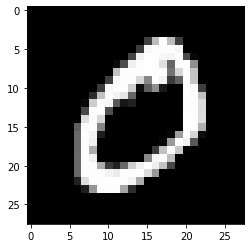

In [5]:
plt.imshow(y.squeeze(), cmap='Greys_r');

In [6]:
###### Architecture ######

NN_ARCHITECTURE = [
    {"input_dim": 784, "output_dim": 512, "activation": "relu"},
    {"input_dim": 512, "output_dim": 512, "activation": "relu"},
    {"input_dim": 512, "output_dim": 10, "activation": "sigmoid"} #Or relu again like the original example
]#No Dropout...yet


######  Init Layers  ######

def init_layers(nn_architecture, seed = 99):
    # random seed initiation
    np.random.seed(seed)
    # number of layers in our neural network
    number_of_layers = len(nn_architecture)
    # parameters storage initiation
    params_values = {}

    # iteration over network layers
    for idx, layer in enumerate(nn_architecture):
        # we number network layers from 1
        layer_idx = idx + 1

        # extracting the number of units in layers
        layer_input_size = layer["input_dim"]
        layer_output_size = layer["output_dim"]

        # initiating the values of the W matrix
        # and vector b for subsequent layers
        params_values['W' + str(layer_idx)] = np.random.randn(
            layer_output_size, layer_input_size) * 0.1
        params_values['b' + str(layer_idx)] = np.random.randn(
            layer_output_size, 1) * 0.1

    return params_values

In [7]:
### Activation Functions ###
def sigmoid(Z):
    return 1/(1+np.exp(-Z))

def relu(Z):
    return np.maximum(0,Z)

def sigmoid_backward(dA, Z):
    sig = sigmoid(Z)
    return dA * sig * (1 - sig)

def relu_backward(dA, Z):
    dZ = np.array(dA, copy = True)
    dZ[Z <= 0] = 0;
    return dZ;

In [8]:
def single_layer_forward_propagation(A_prev, W_curr, b_curr, activation="relu"):
    # calculation of the input value for the activation function
    Z_curr = np.dot(W_curr, A_prev) + b_curr
    
    # selection of activation function
    if activation is "relu":
        activation_func = relu
    elif activation is "sigmoid":
        activation_func = sigmoid
    else:
        raise Exception('Non-supported activation function')
        
    # return of calculated activation A and the intermediate Z matrix
    return activation_func(Z_curr), Z_curr

def full_forward_propagation(X, params_values, nn_architecture):
    # creating a temporary memory to store the information needed for a backward step
    memory = {}
    # X vector is the activation for layer 0 
    A_curr = X
    
    # iteration over network layers
    for idx, layer in enumerate(nn_architecture):
        # we number network layers from 1
        layer_idx = idx + 1
        # transfer the activation from the previous iteration
        A_prev = A_curr
        
        # extraction of the activation function for the current layer
        activ_function_curr = layer["activation"]
        # extraction of W for the current layer
        W_curr = params_values["W" + str(layer_idx)]
        # extraction of b for the current layer
        b_curr = params_values["b" + str(layer_idx)]
        # calculation of activation for the current layer
        A_curr, Z_curr = single_layer_forward_propagation(A_prev, W_curr, b_curr, activ_function_curr)
        
        # saving calculated values in the memory
        memory["A" + str(idx)] = A_prev
        memory["Z" + str(layer_idx)] = Z_curr
       
    # return of prediction vector and a dictionary containing intermediate values
    return A_curr, memory

In [52]:
###### Cost Calculations ######
def NLLLoss(logs, targets):
    out = []
    for i in range(len(targets)):
        out.append(logs[i][targets[i]])
    out = np.array(out)
    
    return -out.sum()/len(out)

def get_cost_value(Y_hat, Y):
    # number of examples
    m = Y_hat.shape[1]
    
    # calculation of the cost according to the formula
    cost = -1 / m * (np.dot(Y, np.log(Y_hat).T) + np.dot(1 - Y, np.log(1 - Y_hat).T))
    return np.squeeze(cost) ### ATTENTION!


###### Accuracy Calculation ######

# an auxiliary function that converts probability into class
def convert_prob_into_class(probs):
    probs_ = np.copy(probs)
    probs_[probs_ > 0.5] = 1
    probs_[probs_ <= 0.5] = 0
    return probs_


def get_accuracy_value(Y_hat, Y):
    Y_hat_ = convert_prob_into_class(Y_hat)
    return (Y_hat_ == Y).all(axis=0).mean()

In [53]:
#######  BACK PROPAGATION  #######

def single_layer_backward_propagation(dA_curr, W_curr, b_curr, Z_curr, A_prev, activation="relu"):
    # number of examples
    m = A_prev.shape[1]
    
    # selection of activation function
    if activation is "relu":
        backward_activation_func = relu_backward
    elif activation is "sigmoid":
        backward_activation_func = sigmoid_backward
    else:
        raise Exception('Non-supported activation function')

    # calculation of the activation function derivative
    dZ_curr = backward_activation_func(dA_curr, Z_curr)
    
    # derivative of the matrix W
    dW_curr = np.dot(dZ_curr, A_prev.T) / m
    
    # derivative of the vector b
    db_curr = np.sum(dZ_curr, axis=1, keepdims=True) / m
    # derivative of the matrix A_prev
    dA_prev = np.dot(W_curr.T, dZ_curr)

    return dA_prev, dW_curr, db_curr 


def full_backward_propagation(Y_hat, Y, memory, params_values, nn_architecture):
    grads_values = {}
    
    # number of examples
    m = Y.shape[1]
    # a hack ensuring the same shape of the prediction vector and labels vector
    Y = Y.reshape(Y_hat.shape)
    
    # initiation of gradient descent algorithm
    dA_prev = - (np.divide(Y, Y_hat) - np.divide(1 - Y, 1 - Y_hat));
    
    for layer_idx_prev, layer in reversed(list(enumerate(nn_architecture))):
        
        # we number network layers from 1
        layer_idx_curr = layer_idx_prev + 1
        # extraction of the activation function for the current layer
        activ_function_curr = layer["activation"]
        
        dA_curr = dA_prev
        
        A_prev = memory["A" + str(layer_idx_prev)]
        Z_curr = memory["Z" + str(layer_idx_curr)]
        
        W_curr = params_values["W" + str(layer_idx_curr)]
        b_curr = params_values["b" + str(layer_idx_curr)]
        
        
        dA_prev, dW_curr, db_curr = single_layer_backward_propagation(
            dA_curr, W_curr, b_curr, Z_curr, A_prev, activ_function_curr)

        grads_values["dW" + str(layer_idx_curr)] = dW_curr
        grads_values["db" + str(layer_idx_curr)] = db_curr

    return grads_values

In [54]:
###### UPDATE ######

def update(params_values, grads_values, nn_architecture, learning_rate):

    # iteration over network layers
    for layer_idx, layer in enumerate(nn_architecture, 1):
        params_values["W" + str(layer_idx)] -= learning_rate * grads_values["dW" + str(layer_idx)]        
        params_values["b" + str(layer_idx)] -= learning_rate * grads_values["db" + str(layer_idx)]

    return params_values;

In [64]:
######  TRAIN  ######
import torch
import time
time.time()


def train(X, Y, nn_architecture, epochs, learning_rate, verbose=True, callback=None):
    # initiation of neural net parameters
    params_values = init_layers(nn_architecture, 2)
    # initiation of lists storing the history 
    # of metrics calculated during the learning process 
    cost_history = []
    accuracy_history = []
    
    ####### Building index labels from One-Hot matrix #######
    temp = []
    #train_labels = train_labels.sum(1)
    for i in range(Y.shape[1]):
        for j in range(Y.shape[0]):
            if(Y[j][i]==1):
                temp.append(j)
    #########################################################
    
    # performing calculations for subsequent iterations
    for e in range(epochs):
        # step forward
        running_loss = 0
        accuracy = 0
        batch = 6000
        for c in range(0, X.shape[1], batch):
            
            #timestamp1 = time.time()
            
            if(X.shape[1] - c < batch):#means that there is a smaller(<32) part left
                batch = X.shape[1] - c
            X_t = X[:][c:(c + batch)]
            Y_t = Y[:][c:(c + batch)]
            
            Y_hat, cashe = full_forward_propagation(X, params_values, nn_architecture)

            print(c)  
            # calculating metrics and saving them in history
            '''
            cross_entropy_loss = torch.nn.CrossEntropyLoss()
            Yh = torch.Tensor(Y_hat)
            print(Y[0][0])
            Ys = torch.LongTensor(Y[0])
            print(Yh.shape)
            print(Ys.shape)
            print(Ys[0])

            cost = cross_entropy_loss(Yh.T, Ys)
            '''
            ''''
            ##############################
            cross_entropy_loss = torch.nn.CrossEntropyLoss()
            temp = []
            #train_labels = train_labels.sum(1)
            for i in range(int(len(Y[:]))):
                temp.append(list(Y[i][:]).index(1))


            #train_labels = np.array(temp.copy())
            Yh = torch.Tensor(Y_hat)
            Ys = torch.LongTensor(Y[0])
            cost = cross_entropy_loss(Yh.T, Ys)



            #train_labels = np.array(temp.copy())
            cross_entropy_loss = torch.nn.CrossEntropyLoss()
            Yh = torch.Tensor(Y_hat.T)
            Ys = torch.LongTensor(Ys)
            cost = cross_entropy_loss(Yh, Ys) #logsoftmax is embedded
            print("Torch: {%f}" %(cost))
            ##############################
            '''
            
    
            Ys = np.array(temp) #        
            Yh = np.array(Y_hat.T)
            
            ############### LogSoftMax  #################
            #x_log=np.log( np.exp(Yh) / np.sum(np.exp(Yh), axis = 1) )  #(60000,10) , we need to add along columns so we get sum of 1 on every example-row
            num = np.exp(Yh)
            den = np.sum(np.exp(Yh), axis = 1)
            
            for i in range(Yh.shape[0]): #60000
                #for j in range(Yh.shape[1]): #10
                Yh[i][:] = np.log(num[i][:] / den[i])  
            #############################################
            
            
            cost = NLLLoss(Yh, np.array(Ys))  #(we need to send image(samples,classes) - Future optimizations needed)
            print("Cost: {%f}" %(cost))
            
            #running_loss += cost
            #cost_history.append(cost)
            #accuracy += get_accuracy_value(Y_hat, Y)
            accuracy = get_accuracy_value(Y_hat, Y)
            #accuracy_history.append(accuracy)
            #print(accuracy)
            # step backward - calculating gradient
            
            grads_values = full_backward_propagation(Y_hat, Y, cashe, params_values, nn_architecture)
            # updating model state
            params_values = update(params_values, grads_values, nn_architecture, learning_rate)
        

            
        #END OF LOOP - EPOCH
        #timestamp2 = time.time()
        #print ("This took %.2f seconds" %(timestamp2 - timestamp1))
        if(verbose):
            print("Epoch: {:5d}   -   cost: {:.5f}   -   Accuracy: {:.2f}%".format(e+1, cost, accuracy*100))
        if(callback is not None):
            callback(i, params_values)
            
    return params_values

In [84]:
###### Training ######
#train_images, train_labels, test_images, test_labels
import gc
gc.collect()

params_values = train(np.transpose(train_images), np.transpose(train_labels.reshape((train_labels.shape[0], 10))), NN_ARCHITECTURE, 2, 0.05)

0
Cost: {2.337527}
6000
Cost: {2.302585}
12000
Cost: {2.217305}
18000
Cost: {2.273744}
24000
Cost: {2.119848}
30000
Cost: {2.112447}
36000
Cost: {2.064187}
42000
Cost: {2.017289}
48000
Cost: {1.974140}
54000
Cost: {1.936778}
Epoch:     1   -   cost: 1.93678   -   Accuracy: 45.13%
0
Cost: {1.904969}
6000
Cost: {1.877998}
12000
Cost: {1.854863}
18000
Cost: {1.834925}
24000
Cost: {1.817523}
30000
Cost: {1.802114}
36000
Cost: {1.788381}
42000
Cost: {1.776059}
48000
Cost: {1.764930}
54000
Cost: {1.754791}
Epoch:     2   -   cost: 1.75479   -   Accuracy: 70.54%
0
Cost: {1.745630}
6000
Cost: {1.737108}
12000
Cost: {1.729490}
18000
Cost: {1.722162}
24000
Cost: {1.715908}
30000
Cost: {1.709195}
36000
Cost: {1.704949}
42000
Cost: {1.697860}
48000
Cost: {1.701082}
54000
Cost: {1.696397}
Epoch:     3   -   cost: 1.69640   -   Accuracy: 73.24%
0
Cost: {1.726744}
6000
Cost: {1.727534}
12000
Cost: {1.739639}
18000
Cost: {1.702173}
24000
Cost: {1.706242}
30000
Cost: {1.682897}
36000
Cost: {1.691199}
4

In [85]:
###### Prediction ######
Yt = test_labels.T
temp1 = []
for i in range(Yt.shape[1]):
        for j in range(Yt.shape[0]):
            if(Yt[j][i]==1):
                temp1.append(j)
Yt=np.array(temp1)
Y_test_hat, _ = full_forward_propagation(np.transpose(test_images), params_values, NN_ARCHITECTURE)#multiple?!

Yht = np.array(Y_test_hat.T)
#x_log=np.log( np.exp(Yh) / np.sum(np.exp(Yh), axis = 1) )  #(60000,10) , we need to add along columns so we get sum of 1 on every example-row
num = np.exp(Yht)
den = np.sum(np.exp(Yht), axis = 1)
for i in range(Yht.shape[0]): #60000
                #for j in range(Yh.shape[1]): #10
                Yht[i][:] = np.log(num[i][:] / den[i])  

#cost = get_cost_value(Yht, Yt)

#cost_history.append(cost)
accuracy = get_accuracy_value(Y_test_hat, test_labels.T)
#accuracy_history.append(accuracy)
print("Accuracy: {:.5f}%".format( accuracy*100))

Accuracy: 79.33000%
